# Predicting Movie Success Using Machine Learning
#### By Zachary Szentimrey, Adesh Kadambi and Rylee Thompson

## Introduction

The purpose of this notebook is to create a model or models which can predict how successful a movie will be. We are defining success as how much money a movie makes and how many Academy Award wins/ nominations they have. The more money and awards, the greater amount of success. The models will be developped using a regression model to determine the amount of money made and a classification model for number of Oscar wins. The accuracy of these models will be found which wll be used to validate the model(s).

## Methodology and Results

In order to predict movie success, data needs to be collected in order to both create the model and test the model. IMDb website will be used to scrape movie data information pertaining to genre, actors involved and parental rating just to name a few. Additionally, a .csv database file will be used to collect Oscar wins/nomination information for actors and directors as this information is not easily accessible on IMDb. Scraping will be performed using Beautiful Soup and scikit-learn will be used to build the models.

The below libraries are used to perform data collection, database manipulation and to build the models. As well, random seeds are selected to ensure approximately the same outcome always occurs (predictable results).

In [1]:
from requests import get
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from numpy import array
from numpy import argmax
from operator import add
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import random
import numpy.random
numpy.random.seed(5)
random.seed(5)

### Working with the Oscar Database 

Following code access the .csv database file attached and preconditions the database in order to gather the data into dictionaries. Of all the Oscar categories that exist, the actors/actresses and director awards are considered the most important as this information is easy to scrape on IMDb. The dictionaries are based on the following categories.

- actorAwards = awards that can be recieved directly by an actor/actress
- directorAwards = awards that can be received directly by a director
- movieAwards = awards that directors and actors can directly influence

In [4]:
actorAwards = ['Actor', 'Actor in a Supporting Role', 'Actress', 'Actress in a Supporting Role', 'Actor in a Leading Role', 
               'Actress in a Leading Role']

directorAwards = ['Directing'] #For this dataset that name of the director is in the 'Film' category

movieAwards = ['Best Motion Picture', 'Outstanding Motion Picture', 'Documentary', 'Documentary (Feature)', 
               'Documentary (Short Subject)', 'Short Subject (Cartoon)', 'Short Subject (One Reel)',
               'Short Film (Animated)', 'Short Film (Live Action)', 'Best Picture', 'Animated Feature Film'] #Movie name is in the 'name' category

#Awards like writing, screenplay, production, etc are saved under other awards as the actor and director do not
#influence them as directly (or at all) as the ones above

OscarRead = pd.read_csv('OscarDatabase.csv') #read the database
yearCSV = OscarRead["Year"] #The year the movie was released
awardCSV = OscarRead["Award"] #The name of the award received/nominated for
winnerCSV = OscarRead["Winner"] #If the entry won or not

resultsCSV = winnerCSV.copy() #Create a copy to edit
resultsCSV[resultsCSV != 1] = 0 #Original CSV has a '1' for winner, and NaN for a nomination - convert NaN to '0'

nameCSV = OscarRead["Name"] 
filmCSV = OscarRead["Film"]

win = 1
nomination = 0

def getDict(awards, result = win, name = nameCSV, film = filmCSV, starAwards = True, otherAwards = False):
    
    Dict = {}
    for i in range(len(yearCSV)):
        if otherAwards == False and awardCSV[i] not in awards or resultsCSV[i] != result:
            continue
        elif otherAwards == True and awardCSV[i] in awards or resultsCSV[i] != result:
            continue
        if starAwards == False:
            try:
                try:
                    Dict[yearCSV[i] + 1][name[i]] += 1 #If the movie wins multiple awards in a year
                except:
                    Dict[yearCSV[i] + 1][name[i]] = 1 #Set the value for movie to one if the year is already in the dictionary
            except:
                Dict[yearCSV[i] + 1] = {} #if year is not in dictionary yet then create it
                Dict[yearCSV[i] + 1][name[i]] = 1 #set the value to one
                #Above code uses year + 1 for the key as the original database has the release year of the movie stored, 
                #not the year of the oscars
        else:
            try:
                try:
                    Dict[yearCSV[i] + 1][name[i]][1] += 1
                except:
                    Dict[yearCSV[i] + 1][name[i]] = film[i], 1
            except:
                Dict[yearCSV[i] + 1] = {}
                Dict[yearCSV[i] + 1][name[i]] = film[i], 1            
    return Dict

Creates a dictionary which contains Oscar wins and nominations for every Oscar that has ever been awarded (1935-2018).If a movie/actor/director wins an award, it is only saved as a winner and will not have an entry for the nomination it received for that award. Displayed from this data is the 1950 oscar winners and oscar nominees. This is to see if the databases are accurate. Additionally, the 2018 oscar winners for awards other than acting, directing and best film are listed.

In [5]:
OscarActorWinners = getDict(actorAwards)
OscarActorNoms = getDict(actorAwards, nomination)
OscarDirWinners = getDict(directorAwards, name = filmCSV, film = nameCSV)
OscarDirNoms = getDict(directorAwards, nomination, name = filmCSV, film = nameCSV)
movieWinners = getDict(movieAwards, starAwards = False)
movieNoms = getDict(movieAwards, nomination, starAwards = False)
otherAwardWinners = getDict(actorAwards + movieAwards + directorAwards, starAwards = False, otherAwards = True)
otherAwardNoms = getDict(actorAwards + movieAwards + directorAwards, nomination, starAwards = False, otherAwards = True)

print("1950 oscar winners (acting) are:", OscarActorWinners[1951])
print("1950 oscar nominees (acting) are:", OscarActorNoms[1950])


otherAwardWinners[2018]

1950 oscar winners (acting) are: {'José Ferrer': ('Cyrano de Bergerac', 1), 'George Sanders': ('All about Eve', 1), 'Judy Holliday': ('Born Yesterday', 1), 'Josephine Hull': ('Harvey', 1)}
1950 oscar nominees (acting) are: {'Kirk Douglas': ('Champion', 1), 'Gregory Peck': ("Twelve O'Clock High", 1), 'Richard Todd': ('The Hasty Heart', 1), 'John Wayne': ('Sands of Iwo Jima', 1), 'John Ireland': ("All the King's Men", 1), 'Arthur Kennedy': ('Champion', 1), 'Ralph Richardson': ('The Heiress', 1), 'James Whitmore': ('Battleground', 1), 'Jeanne Crain': ('Pinky', 1), 'Susan Hayward': ('My Foolish Heart', 1), 'Deborah Kerr': ('Edward, My Son', 1), 'Loretta Young': ('Come to the Stable', 1), 'Ethel Barrymore': ('Pinky', 1), 'Celeste Holm': ('Come to the Stable', 1), 'Elsa Lanchester': ('Come to the Stable', 1), 'Ethel Waters': ('Pinky', 1)}


{'Coco': 1,
 'The Shape of Water': 2,
 'Blade Runner 2049': 2,
 'Get Out': 1,
 'Call Me by Your Name': 1,
 'The Silent Child': 1,
 'Dunkirk': 3,
 'Dear Basketball': 1,
 'A Fantastic Woman': 1,
 'Phantom Thread': 1,
 'Darkest Hour': 1}

As seen below, Gary Oldman won an oscar for his role in Darkest Hour. This ensures the dictionary work and shows the correct results when accessing a key.

In [6]:
OscarActorWinners[2018]['Gary Oldman'][0]

'Darkest Hour'

These are the same as the dictionaries above except that for the starAwards = False tag. Using this simply returns a dictionary of the form Dict[year][actor] = oscars won in year, instead of Dict[year][actor] = movie. Simply makes it easier to deal with just the numbers.

In [7]:
OscarActorWinnersDupe = getDict(actorAwards, starAwards = False)
OscarActorNomsDupe = getDict(actorAwards, nomination, starAwards = False)
OscarDirWinnersDupe = getDict(directorAwards, name = filmCSV, film = nameCSV, starAwards = False)
OscarDirNomsDupe = getDict(directorAwards, nomination, name = filmCSV, film = nameCSV, starAwards = False)

The code below takes in the previous dictionaries and makes a nested dictionary where a running total of Oscar wins for an actor/director is recorded. This means if an actor won an award in the year 1976, the award does not count for movies in which that actor was previously in. The nested dictionary is validated by observing Anthony Quinn's oscar wins. It can be seen he had 1 Oscar in 1953 but by 1957, he had 2 OScars.

In [8]:
startYear = 1934 + 1
endYear = 2018
def getRunningTotal(Dict):

    totalDict = {}
    totalDict[startYear] = Dict[startYear]
            
    for year in range(startYear + 1, endYear + 1):
        totalDict[year] = {}
        totalDict[year].update(totalDict[year - 1]) #update dictionary with previous year to keep a running total each year
    
        for key, value in Dict[year].items():
            try:
                totalDict[year][key] += 1 #if the actor is already present increment by 1
            except:
                totalDict[year][key] = 1 #set it to 1 if not already present
    return totalDict

OscarActorWinnersTot = getRunningTotal(OscarActorWinnersDupe)
OscarActorNomsTot = getRunningTotal(OscarActorNomsDupe)
OscarDirWinnersTot = getRunningTotal(OscarDirWinnersDupe)
OscarDirNomsTot = getRunningTotal(OscarDirNomsDupe)

print(OscarActorWinnersTot[1953]['Anthony Quinn'])
print(OscarActorWinnersTot[1957]['Anthony Quinn']) #Anthony won an Oscar in 1953 and 1957
#OscarActorWinnersTot[2018]

1
2


Just for fun, a list of directors who won more than 1 award and actors who won more than 2 awards are shown below.

In [9]:
print("Directors who have won more than 1 award:")
for key, value in OscarDirWinnersTot[2018].items():
    if value >= 2:
        print(key)
        print(value)


print("Actors who have won more than 2 awards:")        
for key, value in OscarActorWinnersTot[2018].items(): #Actors that won multiple awards (just for fun lol)
    if value >= 3:
        print(key)
        print(value)

Directors who have won more than 1 award:
Frank Capra
3
John Ford
4
Leo McCarey
2
William Wyler
3
Billy Wilder
2
Elia Kazan
2
Joseph L. Mankiewicz
2
George Stevens
2
Fred Zinnemann
2
David Lean
2
Milos Forman
2
Oliver Stone
2
Clint Eastwood
2
Steven Spielberg
2
Ang Lee
2
Alejandro G. Iñárritu
2
Actors who have won more than 2 awards:
Walter Brennan
3
Ingrid Bergman
3
Katharine Hepburn
3
Jack Nicholson
3
Meryl Streep
3


### Web Scraping

In order to get all of the features required to create the prediction model, data from movies needs to be scraped. The website that contains a lot of information on movies is IMDb. This website contains information on thousands of movies including the features below.

- name of the movie
- year the movie was made
- genre of the movie
- movie runtime
- amount of money the movie made
- Metascore
- IMDb rating
- parental/audience rating
- actors and director in the movie
- number of user votes

Below, multiple IMDb URL's are accessed in order to collect information on many movies. Each webpage contain 50 movies so this for loop creates a list of URL's where 50 movies exists on each page. Each URL that is appended to the array is a list of movies released from 1935-2018 sorted by different criteria by IMDd. This is done to maximize the amount of movies collected by our scraper as the URL is no longer consistent once you get to the 10,000th movie. 

In [10]:
urlArray = []

numMovies = 10000 #numMovies % 50 must be 0

for i in range(1, numMovies - 48, 50): #create an array of urls to iterate through
    urlArray.append('https://www.imdb.com/search/title?title_type=feature&release_date=1935-01-01,2017-12-31&sort=boxoffice_gross_us,desc&start=' #gross
                    + str(i) + '&ref_=adv_nxt')
    urlArray.append('https://www.imdb.com/search/title?title_type=feature&release_date=1935-01-01,2017-12-31&start=' + str(i) + '&ref_=adv_nxt') #popularity
    urlArray.append('https://www.imdb.com/search/title?title_type=feature&release_date=1935-01-01,2017-12-31&sort=num_votes,desc&start=' + str(i) + '&ref_=adv_nxt') #numVotes

The function `cleandata()` is used later after collecting the information. This function turns a string of numbers into numeric values or it removes unncessary spacing. This is for the movie year, genre, runtme, box office gross and user votes.

In [11]:
def cleanData(year_, genre, runtime, box_office, votes):
    year1 = ''.join(c for c in year_ if c.isdigit()) #remove non-numeric characters from year
    
    genre1 = ''.join(c for c in genre if (c != '\n')) #original data has '\n' scattered around... remove those
    
    runtime1 = ''.join(c for c in runtime if c.isdigit()) #remove non-numeric characters from runtime
    
    box = ''.join(c for c in box_office if (c.isdigit() or c == '.')) #remove non-numeric characters, but keep the decimal
    box = round(float(box) * (10**6)) #original is in millions
    
    votes1 = ''.join(c for c in votes if c.isdigit()) #remove non-numeric characters from votes
    
    
    return int(year1), genre1, int(runtime1), box, int(votes1)

The function `normalize()` is used to normalize the runtime and movie gross data to be used for the machine learning model. This function will work but the `normalize()` function fom sci-kit learn is used instead later after collecting the data

In [12]:
def normalize(runtime, gross):
    nor_runtime = np.divide(runtime,max(runtime))
    nor_gross = np.divide(gross,max(gross))
    return nor_runtime, nor_gross

The `CPIdict` is a dictionary which contains multiplication values (imported from .csv file) to adjust the box office gross values into today's dollar value.

In [13]:
CPIdict = {}
CPIread = pd.read_csv('CPI.csv') #CPI.csv contains the multiplication factor to get from a given year to 2019 to adjust
                                 #for inflation
for i in range(len(CPIread["Growth"] + 1)):
     CPIdict[CPIread["Year"][i]] = CPIread["To 2019"][i]
print("Movies released in 1990 have a multiplier of", CPIdict[1990], "to their gross to adjust for inflation")

Movies released in 1990 have a multiplier of 1.9345070969999998 to their gross to adjust for inflation


The function `inflationAdjust()` multiplies the gross value by the multiplication factor for the year it was released.

In [14]:
def inflationAdjust(year, box_office):
    return int(round(box_office * CPIdict[year])) 

The function `getOscarNum` is used to evaulate each movie thats is scraped to add the number of Oscar win and nominations to a movie based on the actors and director involved. This function uses the function `checkDict()` in order to accomplish this task. The function returns the nominations and wins in the following order.
1. Previous combined Oscar wins by the actors and directors in the movie
2. Previous combined Oscar nominations by the actors and directors in the movie

3. Number of combined Oscar wins by the actors and directors for this movie only
4. Number of combined Oscar nominations by the actors and directors for this movie only

5. Number of Oscar wins for an Oscar that the directors and actors directly influence for this movie
6. Number of Oscar nominations for an Oscar that the directors and actors directly influence for this movie

7. Number of Oscar wins for this movie that actors and directors don't directly influence
8. Number of Oscar nominations for this movie that actors and directors don't directly influence

In [15]:
def getOscarNum(actor1, actor2, actor3, actor4, actor5, movieName, releaseYear):
    stars = []
    stars.extend([actor1, actor2, actor3, actor4, actor5])
    prevStarWins = prevStarNoms = starWins = starNoms = movieWinsVal = movieNomsVal = otherWins = otherNoms = 0
    oscarYear = releaseYear + 1
    for star in stars:
        if star != '': #Checks how many oscar nominations and wins the directors and actors have prior to this movie
            prevStarWins += checkDict(star, OscarDirWinnersTot, releaseYear) #
            prevStarWins += checkDict(star, OscarActorWinnersTot, releaseYear)
            prevStarNoms += checkDict(star, OscarDirNomsTot, releaseYear)
            prevStarNoms += checkDict(star, OscarActorNomsTot, releaseYear)
            starWins += checkDict(star, OscarDirWinners, oscarYear, movie = movieName)
            starWins += checkDict(star, OscarActorWinners, oscarYear, movie = movieName)
            starNoms += checkDict(star, OscarDirNoms, oscarYear, movie = movieName)
            starNoms += checkDict(star, OscarActorNoms, oscarYear, movie = movieName)
    #Checks num of nominations/wins this movie received
    movieWinsVal += checkDict(movieName, movieWinners, oscarYear)
    movieNomsVal += checkDict(movieName, movieNoms, oscarYear)
    otherWins += checkDict(movieName, otherAwardWinners, oscarYear)
    otherNoms += checkDict(movieName, otherAwardNoms, oscarYear)
    return prevStarWins, prevStarNoms, starWins, starNoms, movieWinsVal, movieNomsVal, otherWins, otherNoms
        
def checkDict(name, Dict, year, movie = None):
    num = 0
    movieName = []
    if movie == None:
        try:
            num += Dict[year][name]       
        except:
            pass
    else:
        try:
            movieName = Dict[year][name][0]
            if movieName == movie:
                num += 1
        except:
            pass
    return num

Below we check that the function `getOscarNum()` works using Gary Oldman. Gary won an award for his role in Darkest Hour so starWins is 1 (third number in the list).

In [16]:
getOscarNum('Gary Oldman', '', '', '', '', 'Darkest Hour', 2017)

(0, 1, 1, 0, 0, 1, 1, 3)

Gary didn't win an award for this movie so starWins is 0 (third number in the list) which is seen below.

In [17]:
getOscarNum('Gary Oldman', '', '', '', '', 'not a real movie', 2017) 

(0, 1, 0, 0, 0, 0, 0, 0)

The number of Oscars Gary has won is increased by one for the next year (1st number in the list).

In [18]:
getOscarNum('Gary Oldman', '', '', '', '', 'not a real movie', 2018)

(1, 1, 0, 0, 0, 0, 0, 0)

The backbone of the web scraping is performed in the next block of code. What this code does is it cycles through each URL that contains 50 movies and extracts the important information feature mentioned earlier. After collecting each feature, the data is cleaned using previously defined functions and appended to a list. As each movie's information is collected, if anything is missing or the same movie appears multiple times, that movie is dropped from the list and the next movie is tried. Each movie that contains missing or duplicated data is returned to show that the web-scraping is working.

Finally, once all the movies are scraped, the appended list is unzipped to create lists of all the features and information collected.

**This part of the notebook can take up to 30 minutes to perform. If you skip this cell the rest of the notebook will still function as normal.**

In [ ]:
names = []
year = []
genres = []
runtimes = []
metascores = []
imdbRatings = []
audienceRating = []
movieGross = []
directors =[]
movieGrossInflation = []
Star1 = []
Star2 = []
Star3 = []
Star4 = []
Star5 = []
res = []
missingData = 0
checkname = []

for url in urlArray:
    response = get(url)
    html_soup = BeautifulSoup(response.text, 'html.parser')
    movie_cont = html_soup.find_all('div', class_ = 'lister-item mode-advanced')
    
    for movie in movie_cont:
        try:
            name = movie.h3.a.text
            if name in checkname:
                raise error
        except:
            continue
        try:
            year_ = movie.h3.find('span', class_ = 'lister-item-year text-muted unbold').text
            genre = movie.p.find('span', class_ = 'genre').text
            runtime = movie.p.find('span', class_ = 'runtime').text
            viewer_rating = movie.p.span.text
            if viewer_rating == runtime:
                print("Runtime error")
                raise Error
            m_score = movie.find('span', class_ = 'metascore').text
            imdb_rating = float(movie.strong.text)
            box_office = movie.find_all('span', attrs = {'name': 'nv'})[1].text
            votes = movie.find_all('span', attrs = {'name': 'nv'})[0].text
            people = movie.find_all('p', class_ = '')[1]
            people = people.find_all('a')
            director = people[0].text
            actor1 = people[1].text
            
            #This try/except block is just in case lesser known movies are missing actors (might happen when
            #numMovies is set to like 10000, and I don't think it's a big deal as long as we have one actor + director)
            try:
                actor2 = people[2].text
            except:
                actor2 = ''
            try:
                actor3 = people[3].text
            except:
                actor3 = ''
            try:
                actor4 = people[4].text
            except:
                actor4 = ''
            try:
                actor5 = people[5].text
            except:
                actor5 =''
            
            checkname.append(name)
            year_, genre, runtime, box_office, votes = cleanData(year_, genre, runtime, box_office, votes) #clean up data
            
            box_office_inflation = inflationAdjust(year_, box_office) #adjust for inflation
            
            numStarWins, numStarNoms, starWin, starNom, numMovieWins, numMovieNoms, numOtherWins, numOtherNoms = getOscarNum(actor1, actor2, actor3, actor4, actor5, name, year_)
                
            res.append((name, year_, genre, runtime, director, actor1, actor2, actor3, actor4, actor5,
                        viewer_rating, m_score, imdb_rating, votes, box_office, box_office_inflation, numStarWins, 
                        numStarNoms, starWin, starNom, numMovieWins, numMovieNoms, numOtherWins, numOtherNoms))
        except:
            print("Missing/Duplicate data for:", name)
            missingData += 1
            
(names, year, genres, runtimes, directors, Star1, Star2, Star3, Star4, Star5, audienceRatings, metascores, 
imdbRatings, numVotes, movieGross, movieGrossInflation, starWinsList, starNomsList, starWon, starNom, movieWinsList, movieNomsList, 
otherWinsList, otherNomsList) = zip(*res)

The data collected using the cell above was written to a CSV, and is read using this cell.

In [32]:
ScrappedData = pd.read_csv('ScrappedDatabase.csv') #read the database
names = ScrappedData["Name"]
year = ScrappedData["Year"]
genres = ScrappedData["Genre"]
runtimes = ScrappedData["Runtime"]
directors = ScrappedData["Director"]
Star1 = ScrappedData["Star1"]
Star2 = ScrappedData["Star2"]
Star3 = ScrappedData["Star3"]
Star4 = ScrappedData["Star4"]
Star5 = ScrappedData["Star5"]
audienceRatings = ScrappedData["Rating"]
metascores = ScrappedData["Metascore"]
imdbRatings = ScrappedData["IMDB rating"]
numVotes = ScrappedData["Votes"]
movieGross = ScrappedData["Gross"]
movieGrossInflation = ScrappedData["Inflation adjusted"]
starWinsList = ScrappedData["numStarW"]
starNomsList = ScrappedData["numStarN"]
starWon = ScrappedData["starWon"]
starNom = ScrappedData["starNom"]
movieWinsList = ScrappedData["numMovieW"]
movieNomsList = ScrappedData["numMovieN"]
otherWinsList = ScrappedData["numOtherW"]
otherNomsList = ScrappedData["numOtherN"]

The number of movies we collected is shown below.

In [33]:
len(names)

6610

This part below takes in the genre list, it creates a dictionary for all the different kinds of genres and puts a number corresponding to each one. Allows for easy calculations when building the machine learning model. Additionally, a new feature is created which takes in the sum of Oscar wins for each movie. Allows for easy classification later on when building the Oscar prediction model.

In [34]:
genresnum = [i.replace(" ","") for i in genres]
diff_genres = list(dict.fromkeys(genresnum))
genre_to_int = dict((c, i) for i, c in enumerate(diff_genres))

In [35]:
winsDupe = list( map(add, movieWinsList, starWon))
wins = list( map(add, winsDupe, otherWinsList))
len(wins)

6610

Some of the parental ratings are very similar in format such as 18A and 18 or PG-13 and 13 so these duplicates are combined into 1 rating. These ratings are then put into a dictionary similar to the genres so a number is assigned to each rating.

In [36]:
audienceRatingsnum = [i.replace(" ","") for i in audienceRatings]
audienceRatingsnum = [i.replace("+", '') for i in audienceRatingsnum]
audienceRatingsnum = [i.replace("14A",'14') for i in audienceRatingsnum]
audienceRatingsnum = [i.replace("18A",'18') for i in audienceRatingsnum]
audienceRatingsnum = [i.replace("PG-13",'13') for i in audienceRatingsnum]
diff_ratings = list(dict.fromkeys(audienceRatingsnum))
ratings_to_int = dict((c, i) for i, c in enumerate(diff_ratings))

### Observing the Database
All the data has now been collected and cleaned to be in proper formats. The actualy database is then collected into 1 dataframe using the pandas library.

In [38]:
df = pd.DataFrame({'Name': names,
                  'Year': year,
                #'Genre': genres,
                  'Genre': genresnum,
                  'Director': directors,
                  'Star1' : Star1,
                  'Star2' : Star2,
                  'Star3' : Star3,
                  'Star4' : Star4,
                  'Star5' : Star5,
                  'Runtime': runtimes,
                  'Rating': audienceRatingsnum,
                  # 'Rating': audienceRatings,
                  'Metascore': metascores,
                  'IMDB rating': imdbRatings,
                  'Votes': numVotes,
                  'Gross': movieGross,
                  'Inflation adjusted':movieGrossInflation,
                  'Total Oscar Wins':wins,
                  'numStarW' : starWinsList,
                  'numStarN' : starNomsList,
                  'starWon' : starWon,
                  'starNom' :starNom,
                  'numMovieW' : movieWinsList,
                  'numMovieN' : movieNomsList,
                  'numOtherW' : otherWinsList,
                  'numOtherN' : otherNomsList})

The code below applies the conversion dictionaries for genres and parental ratings. Additionally, the Metascores for all the movies are converted from string to numbers as this was not performed earlier.

In [39]:
df['Rating'] = df['Rating'].apply(lambda x:ratings_to_int[x])
df['Genre'] = df['Genre'].apply(lambda x:genre_to_int[x])
df['Metascore'] = df['Metascore'].apply(lambda x:int(x))

The actors and directors columns can be dropped fomr the datalist since these columns are converted to numbers based on the Oscar wins and nominations. We want to use only numeric data for the model.

In [40]:
X = df['Inflation adjusted']
y = df.drop('Name', axis = 1)
y = y.drop('Director', axis=1)
y = y.drop('Star1', axis=1)
y = y.drop('Star2', axis=1)
y = y.drop('Star3', axis=1)
y = y.drop('Star4', axis=1)
y = y.drop('Star5', axis=1)
y = y.drop('Gross', axis=1)
y = y.drop('Inflation adjusted', axis=1)
y = y.drop('starWon', axis=1)
y = y.drop('starNom', axis=1)
y = y.drop('numMovieW', axis=1)
y = y.drop('numMovieN', axis=1)
y = y.drop('numOtherW', axis=1)
y = y.drop('numOtherN', axis=1)
y = y.drop('Total Oscar Wins', axis=1)

The new updated database head can be seen below. This database is the one that will be used for creating the prediction models.

In [41]:
y.head()

,Year,Genre,Runtime,Rating,Metascore,IMDB rating,Votes,numStarW,numStarN
0,2015,0,136,0,81,8.0,777758,0,0
1,2009,0,162,0,83,7.8,1034881,0,2
2,1997,1,194,0,75,7.8,946636,1,2
3,2015,2,124,0,59,7.0,534062,0,0
4,2012,2,143,0,69,8.1,1162379,0,4


The X database only contains the adjusted box office gross of the movies which is used to predict movie success using regression models.

In [42]:
X.head()

0     998872170
1     896004440
2    1038221796
3     695593225
4     686255742
Name: Inflation adjusted, dtype: int64

### Building the Regression Model to Predict Box Office Gross
The models will be created using the scikit-learn as it is a simple to use library with a lot of functionality. The first part of creating the model is to separate the data into training and test data. After separating the data, a simple linear regression model will be made using and the accuracy of this model will be validated.

The below code separates the training and testing data randomly. 90% of the data is for training and 10% is for testing.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(y, X, test_size=0.1, random_state=1)

The below code normalizes the data that isn't already normalized. It is best practice and ensure no features are weighted more than others simply because they contain larger values. The data is then printed to ensure it is normalized.

In [44]:
scaler = StandardScaler()
scaler.fit(X_train)

from sklearn.preprocessing import normalize

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_norm = normalize(y,axis=0)
yn =pd.DataFrame(columns=('Year','Genre','Runtime','Rating','Metascore','IMDB rating','Votes','numStarW','numStarN'),data=y_norm)
yn

C:\Users\rylee\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rylee\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\rylee\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


,Year,Genre,Runtime,Rating,Metascore,IMDB rating,Votes,numStarW,numStarN
0,0.012371,0.000000,0.015322,0.000000,0.016996,0.014973,0.054474,0.000000,0.000000
1,0.012334,0.000000,0.018251,0.000000,0.017415,0.014599,0.072483,0.000000,0.010109
2,0.012261,0.000116,0.021856,0.000000,0.015737,0.014599,0.066303,0.015686,0.010109
3,0.012371,0.000231,0.013970,0.000000,0.012380,0.013102,0.037406,0.000000,0.000000
4,0.012353,0.000231,0.016110,0.000000,0.014478,0.015161,0.081413,0.000000,0.020218
5,0.012383,0.000000,0.017124,0.000000,0.017835,0.013476,0.031751,0.000000,0.000000
6,0.012328,0.000347,0.017124,0.000000,0.017625,0.016845,0.142832,0.031373,0.025272
7,0.012377,0.000231,0.014984,0.000000,0.013639,0.014599,0.032972,0.000000,0.005054
8,0.012383,0.000463,0.014533,0.000000,0.013639,0.013476,0.016379,0.000000,0.000000
9,0.012377,0.000579,0.010928,0.003341,0.016156,0.013663,0.014752,0.000000,0.005054


After normalizing and standardizing the data, a principle component analysis (PCA) is performed to determine if any of the features can be dropped to reduce dimensions.

In [45]:
pca = PCA()
final = pca.fit_transform(y_norm)
final.shape

(6610, 9)

A plot of the PCA can be seen below. This shows that almost 95% of the data is contained in approximately 4 or 5 features.

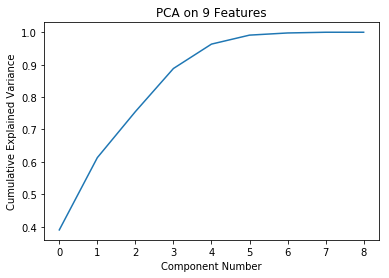

In [46]:
pca.n_components_
f=plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Component Number')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA on 9 Features')
plt.show()
f.savefig('PCA.pdf', bbox_inches='tight')

We only use 5 features as that is all that is needed to represent the data.

In [47]:
pca = PCA(n_components=5)
final = pca.fit_transform(y_norm)
pca.n_components_

5

The training and testing data is transformed to only contain the 5 features.

In [48]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

#### Generalized Linear Regression Model

The code below fits the training data to a linear regression model by attempting to minimize error. The trained model is then used to predict how much money a movie makes with the testing data.

In [49]:
linear = linear_model.LinearRegression()
linear.fit(X_train, y_train)
prediction = linear.predict(X_test)
X_train

array([[-0.53362982,  0.49425311, -0.50867769, -1.10049309,  0.0384184 ],
       [-0.31187044,  1.35867555, -0.21832873,  0.36702259,  0.13711849],
       [-0.84614143, -0.22271395,  0.84597354, -0.3246825 ,  0.08997548],
       ...,
       [-0.79305749, -0.11377385, -0.61176592, -0.87688552,  0.05234121],
       [ 1.8864133 ,  0.5463242 , -0.39268497, -0.7212512 , -0.28625586],
       [-1.03563745, -0.47948728, -1.23529692,  0.94219009,  0.0934671 ]])

The below code shows the percentage of correct predictions as we increase the bounds of the accuracy of the model. When the bounds are around +/- 100,000 dollars, the percentage of correct predictions is approximately 0%. When the bounds are at +/- 100,000,000 dollars, the percentage of correct predictions is approximately 90%.

C:\Users\rylee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\rylee\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in longlong_scalars
  


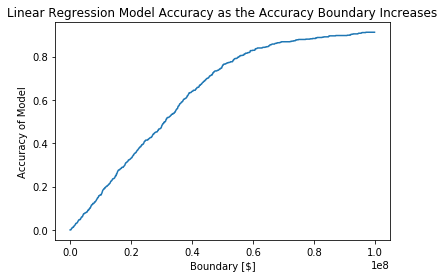

In [50]:
testValues = y_test.as_matrix(columns = None)
lists =[]
numcorrect = []
boundary = []
i = 0
correct = 0
j = 0
for j in range(100000, 100000000, 100000):
    i = 0
    correct = 0
    for i in range(len(prediction)):
        if -j <= (prediction[i] - testValues[i]) and (prediction[i] - testValues[i]) <= j:
            correct += 1
            lists.append(j/testValues[i])
        i += 1
    numcorrect.append(correct/i)
    boundary.append(j)

f=plt.figure()
plt.plot(boundary, numcorrect)
plt.xlabel('Boundary [$]')
plt.ylabel('Accuracy of Model')
plt.title('Linear Regression Model Accuracy as the Accuracy Boundary Increases')
plt.show()
f.savefig('Lin_Reg.pdf', bbox_inches='tight')

#### Decision Tree Regression Model

From the above graph, it can be seen that the linear regression model performs very badly for this data when trying to predict how much money a movie will earn at the box office. Another model will be used to see if an improvement can be made on the results. A decision tree will be used. The depth used will be 20. The deeper the tree, the more complex the decision rules and the fitter the model. In order to verify if it is overfit, the accuracy will be checked using test data (completely separate from the training data).

The model is trained below using a depth of 20 which is plenty in order to represent the data non-linearity.

In [51]:
regr = DecisionTreeRegressor(max_depth=20, random_state=1)
regr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

The test data is then applied to the trained model. The test data was not used for the training so the test data will be the first time the model sees them.

In [52]:
mlpprediction = regr.predict(X_test)

Again plot the accuracy of the model as the boundary (predicted money made +/- the accuracy boundary) increases. It shows a better result than the linear regression model. Its seen that with a boundary of +/- $20,000,000, the decision tree model has an accuracy of approximately 50 percent while the linear regression model only has an accuracy of 30 percent. This is a large improvement and overfitting is not present as the test data performs very well.

C:\Users\rylee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\rylee\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in longlong_scalars
  


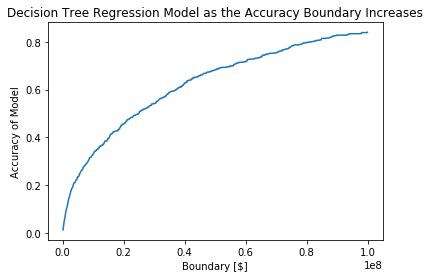

In [53]:
testValues = y_test.as_matrix(columns = None)
lists =[]
numcorrect = []
boundary = []
i = 0
correct = 0
j = 0
for j in range(100000, 100000000, 100000):
    i = 0
    correct = 0
    for i in range(len(mlpprediction)):
        if -j <= mlpprediction[i] - testValues[i] and (mlpprediction[i] - testValues[i]) <= j:
            correct += 1
            lists.append(j/testValues[i])
        i += 1
    numcorrect.append(correct/i)
    boundary.append(j)

f = plt.figure()
plt.plot(boundary, numcorrect)
plt.xlabel('Boundary [$]')
plt.ylabel('Accuracy of Model')
plt.title('Decision Tree Regression Model as the Accuracy Boundary Increases')
plt.show()
f.savefig('Dec_Tree.pdf', bbox_inches='tight')

### Building Classification Model to Predict Oscar Wins

The next criteria of success that will be tracked is whether a movie will win an Oscar. This model will be simpler in that there are a limited number of classes. Since the most Oscars won by by a movie (for acting, directing and best picture win only) is 6. The classes will be split into 6 classes (based on number of Oscar wins).

The dependent variable is chosen to be the total number of Oscar wins in terms of acting, directing and best picture win (as these are seen as the most prestigious awards).

In [54]:
X = df['Total Oscar Wins']
y = df.drop('Name', axis = 1)
y = y.drop('Director', axis=1)
y = y.drop('Star1', axis=1)
y = y.drop('Star2', axis=1)
y = y.drop('Star3', axis=1)
y = y.drop('Star4', axis=1)
y = y.drop('Star5', axis=1)
y = y.drop('Gross', axis=1)
y = y.drop('Inflation adjusted', axis=1)
y = y.drop('starWon', axis=1)
y = y.drop('starNom', axis=1)
y = y.drop('numMovieW', axis=1)
y = y.drop('numMovieN', axis=1)
y = y.drop('numOtherW', axis=1)
y = y.drop('numOtherN', axis=1)
y = y.drop('Total Oscar Wins', axis=1)

The data is split between testing and training (80, 20 split)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(y, X, test_size=0.2, random_state=1)

Once again the data is normalized/standardize in order to prevent any bias in weightings between features.

In [56]:
scaler = StandardScaler()
scaler.fit(X_train)

from sklearn.preprocessing import normalize

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_norm = normalize(y,axis=0)

C:\Users\rylee\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rylee\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\rylee\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


A principle component analysis is performed below where the normalized data is used to determine which features are most important

In [57]:
pca = PCA()
final = pca.fit_transform(y_norm)
final.shape

(6610, 9)

The cdf for the PCA analysis can be seen below. It appears as though 95% of the covaraince is represented in only 5 features so the dimension of the data (number of features) will be reduced to 5.

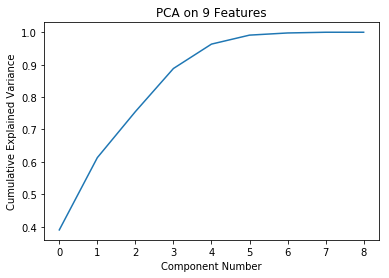

In [58]:
pca.n_components_
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Component Number')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA on 9 Features')
plt.show()

In [59]:
pca = PCA(n_components=5)
final = pca.fit_transform(y_norm)
pca.n_components_

5

The training and test data is then transformed to be only the 5 most important features

In [60]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

#### Naive Bayes Classification Model

The first classification model used is the Naive Bayes model. This model assumesn conditional independence between every pair of features given the value of the class variable. more specifically a Gaussian Naive Bayes model is used.

The code below is used to train the model with the training data. Then the prediction of Oscar wins is found for the test data to see how well the model works. The accuracy is found for the model to determine how well it classifys the data. It seems the classifier is really good at predicting Oscar wins but the confusion matrix will now be plotted.

In [61]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
class_names = ('0 Oscars','1 Oscar','2 Oscars','3 Oscars','4 Oscars','5 Oscars', '6 Oscars','7 Oscars')

Accuracy: 0.9341906202723147


The code below contains a function `plot_confusion_matrix` which takes in the predicted and actual labels for each movie and plots, in a visual way, how accurate each class was predicted  (function taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html). The normalized and non-normalized plots can be seen for the Gaussian Naive Bayes model below. The accuracy is really good for predicting 0 Oscar wins but is very poor at predicting any Osars wins above 0. The data is very skewed with many movies that have 0 Oscar wins so the accuracy seen in the previous code block is not actually as good as it looks.

Confusion matrix, without normalization
[[1234   50    0]
 [  34    1    0]
 [   3    0    0]]
Normalized confusion matrix
[[0.96 0.04 0.  ]
 [0.97 0.03 0.  ]
 [1.   0.   0.  ]]


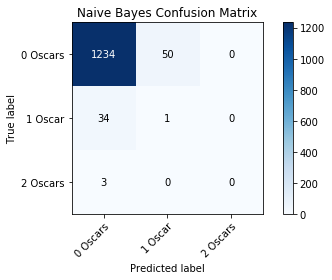

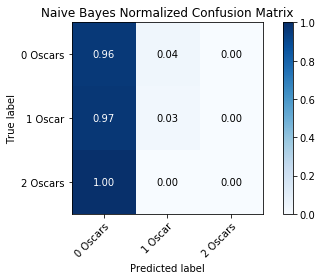

In [62]:
def plot_confusion_matrix(y_true, y_pred, classes, d,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'


    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if d ==1:
        fig.savefig('Bayes_norm.pdf')
    elif d == 0:
        fig.savefig('Bayes.pdf')
    elif d == 2:
        fig.savefig('SVM.pdf')
    elif d == 3:
        fig.savefig('SVM_norm.pdf')
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred, classes=class_names, d=0,
                      title='Naive Bayes Confusion Matrix')

plot_confusion_matrix(y_test, y_pred, classes=class_names, d=1, normalize=True,
                      title='Naive Bayes Normalized Confusion Matrix')

#### Support Vector Classification Model
To see if we can improve on the previous results using a Naive Bayes model, a support vector machine is used. This model will be used to see if improvement can be made, specfically in non-linear classification. The kernel `rbf` is used since it is good at predicting non-linear boundaries and from the regression models, it appears as though the features show many non-linear relationships.

The code below creates an SVC model and fits it to the training data.

In [63]:
clf = svm.SVC(gamma=0.001, C=100., random_state=1,verbose=True)
clf.fit(X_train, y_train)

[LibSVM]

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=True)

The model is then tested with the test data to predict Oscar wins. Accuracy of the model is found to determine if there are improvements to the previous Naive Bayes model.

In [64]:
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9712556732223904


The accuracy is very high so to see how the results are spread, confusion matrices are then plotted.

Confusion matrix, without normalization
[[1284    0    0]
 [  35    0    0]
 [   3    0    0]]
Normalized confusion matrix
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


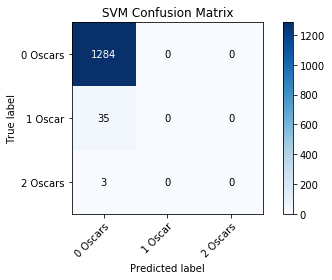

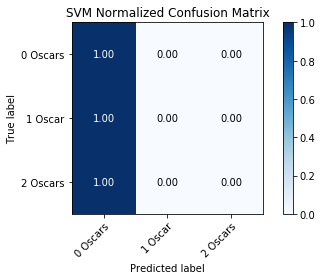

In [65]:
np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred, classes=class_names, d=2,
                      title='SVM Confusion Matrix')

plot_confusion_matrix(y_test, y_pred, classes=class_names, d=3, normalize=True,
                      title='SVM Normalized Confusion Matrix')

As seen above, the results are even worse than before; the SVM model only predicted movies would win 0 Oscars. This explains the high accuracy found above as most movies do not win an Oscar.

### Conclusion

It was found that decision trees are very good in predicting how much money a movie will make. It does this due to the non-linearity in the spread of data. This non-linear relationship in the data means that a model such as a generalized linear regression model would produce poor results (which was seen previously).

From these results classification models were then used to predict the number of Oscar wins. A simple Gaussian Naive Bayes model was used first because it is fast to train (only compare each data point features to the average of the class features) even though it is generally not a very good estimator (it assumes independent features which almost never occurs in real life). The accuracy was found to be high but the data is very skewed to 0 Oscar wins. So the accuracy is not as high as it appears for predicting movies that did win Oscars. An SVM model was then used due to the large non-linearities in the data. From the SVM model, it was seen that the accuracy was better than the Bayes model, however the skew to 0 Oscar wins is even more noticeable, as it didn't predict that any movies would win an Oscar. 